## Catpole 환경에서 DQN 및 DDQN, Dueling network 적용 


## OpenAI Gym Cartpole Environmnet 

Cartpole 환경 설명 

CartPole-v1 환경은 이름 그대로 어떤 Cart에 Pole이 연결되어 있습니다. 위의 그림에서 보라색 사각형은 피벗 포인트를 나타냅니다. 빨간색 및 녹색은 이 피벗 포인트에 적용될 수 있는 수평적 힘을 나타냅니다. Agent의 목표는 Cart를 왼쪽 오른쪽으로 힘을 주면서, 최대한 쓰러트리지 않고 평형을 유지하는게 목표입니다.  

밑의 자료는 MDP 정의를 위한 , Action, reward , state들을 요약 정리한 자료입니다. 


 Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
        
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
        
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
        
    Reward:
        Reward is 1 for every step taken, including the termination step
  
  
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
        
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.

## 환경 탐구

In [ ]:
import gym

env = gym.make('CartPole-v0')

In [ ]:
env.observation_space.sample() # [Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity]

array([ 3.6872673e+00,  2.7864755e+38,  2.7024955e-01, -3.3661892e+38],
      dtype=float32)

In [ ]:
print(env.action_space)
print(env.action_space.sample()) # 0 :Push cart to the left , 1 :Push cart to the right

Discrete(2)
0


## 적용한 알고리즘 코드 설명 

기본적인 구조와  간단한 설명을 하고, 자세한 코드 설명은 주석을 통해서 달았습니다.

## DQN with target network & experience replay buffer
가독성을 위해 Q-network 와 experience replay buffer class를 따로 만들고

Agent class에 결합방하는 방식을 취했습니다.

### Class : Q network
pytorch frame work을 사용했습니다. 

keras에 비해 좀더 익숙하고, 구현이 직관적이라고 판단했습니다. 

아주 간단한 형태로 구성했으며, State(4개 element로 이루어진 array)을 받아 Fully connected layer 3개를 거쳐 

현재 state에서 가능한 action 2개의 Q-value를 output로 내뱉습니다.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Q_network(nn.Module):
    def __init__(self):  
        super(Q_network, self).__init__()
        self.fc1 = nn.Linear(4, 128) #  fully connected  layer 1 : 4개의 state 받아 128개의 output 
        self.fc2 = nn.Linear(128,64)  #  fully connected  layer 2 : 128개의 fc1 output받아 64 개의 output 
        self.fc3 = nn.Linear(64,2) # fully connected  layer 3 : 64개의 fc3 output받아 2 개의 Q-value output 

    def forward(self, x):
        # init에서 지정한 형태의 arictecture를  activation(relue)를 거쳐 forward propagation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        return x 
    

### Class : Experience Replay buffer 

파이썬의 deque 자료 구조를 experience Replay buffer를 구현하기 위해 사용했습니다.

In [ ]:
import random
from collections import deque

class Replay_buffer:
    def __init__(self, size_limit=100000, sample_size=512):
        self.buffer = deque() # 파이썬의 deque 자료구조를 이용합니다
        self.size_limit = size_limit # deque의 최대 element 저장 개수를 지정합니다.
        self.sample_size = sample_size # random sampling할 sampling size를 지정합니다.

    def put(self, data):
        self.buffer.append(data) # data를 받아 buffer에 저장합니다.
        if len(self.buffer) > self.size_limit: # 만약 최대 저장 개수보다 클시, 앞에서 부터 데이터를 pop합니다.
            self.buffer.popleft()

    def sample(self): # 저장된 buffer에서 지정한 sample size만큼 random sampling을 합니다.
        return random.sample(self.buffer, self.sample_size)

    def size(self): # 현재 buffer의 size를 return합니다>
        return len(self.buffer)

### Class : DQN_Agent

본격적으로 Agent Class를 위에서 만든 class들과 결합해 구현합니다. 

exploration rate을 decaying 하면서 효율적으로 exploration exploit을 하도록 하였습니다.

exploration 정책은 step_done과 지정된 exploration rate/min/deacy 값을 기준으로 계산됩니다. 

지수적으로 exploration rate을 감소시키는 효과가 있습니다.

epsilon threshold 값을 기준으로 greedy action을 수행하거나, random action을 수행합니다. 

threshold를 계산하는 공식은 다음과 같습니다.

 eps_threshold = self.exploration_min+ (self.exploration_rate -self.exploration_min) * math.exp(-1. * self.steps_done / self.exploration_decay)




###  init 구성요소 설명 

#### hyper parmeter 

+ learning_rate : optimizer의 learning rate를 결정합니다.
+ gamma : bellmen 방정식의 gamma를 의미합니다.
+ explortation_rate : e-greedy decaying 방식을 취할때 시작 exploration rate를 의미합니다
+ exploration_min : decaying을 하면서, 최소한의 explortation min을 설정합니다. 이 이상은 decaying 하지 않습니다.
+ exploration_decay : 값을 높일수록 천천히, 지수형태로 exploration rate이  decaying 됩니다. 
+ sample_batch_size : replay buffer에서 random sampling 할 개수를 지정합니다.
+ max_memory : replay buffer의 용량을 결정합니다.
+ optimizer : torch의 Adam optimizer를 사용했습니다.
+ epochs : replay method를 사용할때 sampling을 해서 update하는 과정을 얼마나 반복적으로 할것인가를 나타냅니다.

#### 구성요소  
앞서 정의한 replay buffer class와, Q_network를 결합합니다 

+ self.replay_buffer : 앞서 정의한 replay buffer class를 결합합니다. 
+ self.brain : 앞에 정의한 actual Q-network입니다.
+ self.target_brain : target Q-network 이며, 일정 시간 freeze 된 후 actual Q-network의 파라미터를 카피합니다.

#### exploration을 위한  요소 
+ steps_done : 한 episode가 증가할때마다 steps_done+=1 됩니다 .
+ current_eps : 현재 exploration_rate를 추적하기 위해서 만들었습니다.

#### Method
+ random_act : random.randint(0,1)를 이용해 랜덤 action을 return 합니다.
+ epsilon_greedy_action : 계산된 epsilon threshold 값을 기준으로 greedy action을 수행하거나, random action을 수행합니다. 
+ replay : replay buffer에서 random sample을 한후 실제 network를 업데이트 합니다 (지정한 epoch 만큼 수행합니다)
+ update_target_brain : 호출시 현재 actual Q-network의 weight를 카피해서 target network weight을 update합니다.


**처음에는 mse로 loss function을 지정했지만, 잘 안되서  F.smooth_l1_loss function을 사용했습니다**

![image.png](attachment:image.png)

In [ ]:
import math

class DQN_Agent:
    def __init__(self, learning_rate=0.005, gamma=1.0, exploration_rate=1.0, exploration_min=0.1,
                 exploration_decay=200, sample_batch_size=512, max_memory=100000, epochs=10,seed=1):
        
        torch.manual_seed(seed)
        # hyper parameter
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.exploration_rate = exploration_rate
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay
        self.sample_batch_size = sample_batch_size
        self.max_memory = max_memory
        self.epochs = epochs
        
        
        self.replay_buffer = Replay_buffer(size_limit=max_memory, sample_size=sample_batch_size)
        self.brain = Q_network()
        self.target_brain = Q_network()
        self.target_brain.load_state_dict(self.brain.state_dict())
        self.optimizer = optim.Adam(self.brain.parameters(), lr=self.learning_rate)
        
        self.steps_done = 0
        self.current_eps = 0 

    def random_act(self): 
        return random.randint(0,1)
        

    def epsilon_greedy_action(self, state):
        u = np.random.rand()
        
        eps_threshold = self.exploration_min+ (self.exploration_rate -self.exploration_min) * \
        math.exp(-1. * self.steps_done / self.exploration_decay)
        self.current_eps = eps_threshold
        
        #greedy action 
        if u > eps_threshold:
            with torch.no_grad():
                out = self.brain(torch.tensor(state, dtype=torch.float)) # 현재 state를 받아 Qvalue output
                return out.argmax().item() # Q-value 중 가장 큰 action을 return

        # random action
        else:
            return self.random_act()

            

    def replay(self):
        self.target_brain.eval()
        self.brain.train()
        for i in range(self.epochs):
            mini_batch = self.replay_buffer.sample() #replay buffer에서 random sampling 
            
            # mini batch 구성
            state_list, action_list, reward_list, next_state_list, done_list = [], [], [], [], []
            
            # tuple로 구성된 trainsition (s, a, r, s`, done)을 분리
            for transition in mini_batch: 
                state, action, reward, next_state, done = transition  # unpack
                state_list.append(state)
                action_list.append([action])
                reward_list.append([reward])
                next_state_list.append(next_state)
                done_list.append([done])

            # 토치 텐서로 변경
            state, action, reward, next_state, done = torch.tensor(state_list, dtype=torch.float), torch.tensor(action_list), \
                               torch.tensor(reward_list, dtype=torch.float), torch.tensor(next_state_list,dtype=torch.float),\
                               torch.tensor(done_list)
            
            q_out = self.brain(state) # state를 forward propagate Q_value 산출
            q_a = q_out.gather(1, action)  # 그중 실제 취한 action의 Q_value, Q(s,a)
    
            max_q_prime = self.target_brain(next_state).max(1)[0].unsqueeze(1) # max Q(s`,a`) 계산
            target = reward + self.gamma * max_q_prime *done # target, r+ gamma * max Q(s`,a`)
            
            # loss = r+gamma*max(s`,a`) - Q(s,a)
            loss = F.smooth_l1_loss(target, q_a) 
            
            self.optimizer.zero_grad() 
            loss.backward() # backpropagate 
            self.optimizer.step() # update weight

    def update_target_brain(self):
        # copy weight of learned brain to target brain
        self.target_brain.load_state_dict((self.brain.state_dict()))

## Main Function

In [ ]:
import datetime
import time
import numpy as np

# hyper parameter setting
LR = 0.0001
GAMMA = 0.98
MAX_MEMORY = 50000
SAMPLE_BATCH_SIZE =64
EXPLORATION_RATE = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY= 300
EPISODE = 10000
UPDATE_INTERVAL = 20 # target network update 주기 설정

# for display and result checking 
PRINT_INTERVAL = 100
DISPLAY = True



# build environment
env = gym.make('CartPole-v1')
agent = DQN_Agent(learning_rate=LR, gamma=GAMMA, exploration_rate=EXPLORATION_RATE,
              exploration_decay=EXPLORATION_DECAY,
              exploration_min=EXPLORATION_MIN, sample_batch_size=SAMPLE_BATCH_SIZE, max_memory=MAX_MEMORY,
              )


performence = 0
frames = []
result_DQN = [] # 결과 저장용 

for epi_i in range(EPISODE):
    state = env.reset() 
    done = False 

    while True : # 한 episode가 끝날때 까지 
        action = agent.epsilon_greedy_action(state) # 현재 e-greedy 정책에 의해 action을 선택
        next_state, reward, done, _ = env.step(action) # action을 한뒤 env부터 transition 결과 받음
        done_mask = 0.0 if done else 1.0 # epside가 끝나면 done , boolean to float 로 변경 
        agent.replay_buffer.put((state, action, reward/100, next_state, done_mask)) # replay buffer 저장
        state = next_state  # state transition
        performence+=reward # 받은 reward를 누적 
        
        # DISPALY = TRUE로 설정시, 평균 reward가 350번을 넘으면 한번만 rendering 합니다(계속하면 너무 오래걸려서..)
        # if DISPLAY and (performence/PRINT_INTERVAL > 400) :
        #     frames.append(env.render(mode = 'rgb_array'))
        #     env.render()
        #     time.sleep(0.01) 
        #     DISPLAY=False  
        
        if done : 
            agent.steps_done+=1 # e-greedy 정책을 위해 한번 episode가 끝나면 steps_done +1 해줌 
            break  # 끝나면 While True문 탈출
    
    # buffer에 충분히 sample이 저장되면, replay 학습 
    if agent.replay_buffer.size() > 2000 :
        agent.replay()
    
    # target network의 weight를 actual network의 weight으로 update_interval 마다 카피해서 update
    if (epi_i % UPDATE_INTERVAL)==0 and epi_i !=0 : 
        agent.update_target_brain()
    
    # PRINT INTERVAL 동안 평균 reward, exploration_rate, buffer size를 checking 
    if (epi_i % PRINT_INTERVAL)==0 and epi_i !=0 :
        print(f'episode {epi_i}, performence : {(performence/PRINT_INTERVAL):.3f}, eps : {agent.current_eps:.3f}, buffer size {agent.replay_buffer.size()}')
        result_DQN.append(performence/PRINT_INTERVAL) # PRINT INTERVAL 동안 평균 reward,  결과 시각화를 위한 저장 
        performence = 0.0 
        
env.close()

episode 100, performence : 19.620, eps : 0.719, buffer size 1962
episode 200, performence : 27.100, eps : 0.518, buffer size 4672
episode 300, performence : 128.130, eps : 0.374, buffer size 17485
episode 400, performence : 249.890, eps : 0.271, buffer size 42474
episode 500, performence : 329.470, eps : 0.197, buffer size 50000
episode 600, performence : 328.530, eps : 0.144, buffer size 50000
episode 700, performence : 295.720, eps : 0.106, buffer size 50000
episode 800, performence : 295.310, eps : 0.079, buffer size 50000
episode 900, performence : 283.260, eps : 0.059, buffer size 50000
episode 1000, performence : 238.190, eps : 0.045, buffer size 50000
episode 1100, performence : 234.050, eps : 0.035, buffer size 50000
episode 1200, performence : 252.690, eps : 0.028, buffer size 50000
episode 1300, performence : 237.250, eps : 0.023, buffer size 50000
episode 1400, performence : 236.650, eps : 0.019, buffer size 50000
episode 1500, performence : 195.010, eps : 0.017, buffer size

Text(0.5, 1.0, 'DQN result Visualization')

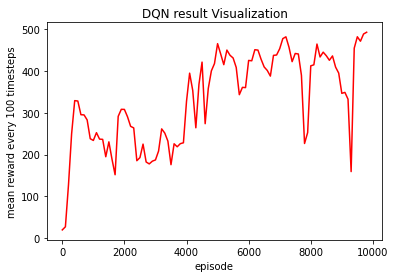

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(0,len(result_DQN*100),100), result_DQN, color='red')
plt.xlabel("episode")
plt.ylabel("mean reward every 100 timesteps")
plt.title("DQN result Visualization")

### Double DQN 

사실 위의 DQN결과는 하이퍼 파라미터 최적화를 한참 뒤에 성공한 뒤 받은 결과이고 처음에는 별로 좋지 않았습니다. 그래서 Double DQN, Dueling Architecture등을 시도 하였습니다. 
Double DQN은 DQN과 코드가 동일하고 loss를 계산하는 부분만 바뀌므로, 그 부분만 설명하도록 하겠습니다.

### DDQN Target 
Actual Q-network에서 
next_state에서 가장 높은 Q값을 가진 action을 선택합니다(a_max_out_brain_index)
이제 target_Q_network에서 해당 action의 Q_value를 재계산합니다. (DDQN_target_value) 
즉, target을 계산하고 loss를 역전파 하는 과정만 바뀐 것입니다.
DQN과 성능 비교를 위해 동일한 하이퍼 파라미터를 세팅을 하고 학습을 진행했습니다.



In [ ]:
import math

class DDQN_Agent:
    def __init__(self, learning_rate=0.005, gamma=1.0, exploration_rate=1.0, exploration_min=0.1,
                 exploration_decay=200, sample_batch_size=512, max_memory=100000, epochs=10,seed=1):
        
        torch.manual_seed(seed)
        # hyper parameter
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.exploration_rate = exploration_rate
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay
        self.sample_batch_size = sample_batch_size
        self.max_memory = max_memory
        self.epochs = epochs
        
        
        self.replay_buffer = Replay_buffer(size_limit=max_memory, sample_size=sample_batch_size)
        self.brain = Q_network()
        self.target_brain = Q_network()
        self.target_brain.load_state_dict(self.brain.state_dict())
        self.optimizer = optim.Adam(self.brain.parameters(), lr=self.learning_rate)
        
        self.steps_done = 0
        self.current_eps = 0 

    def random_act(self): 
        return random.randint(0,1)
        

    def epsilon_greedy_action(self, state):
        u = np.random.rand()
        
        eps_threshold = self.exploration_min+ (self.exploration_rate -self.exploration_min) * \
        math.exp(-1. * self.steps_done / self.exploration_decay)
        self.current_eps = eps_threshold
        
        #greedy action 
        if u > eps_threshold:
            with torch.no_grad():
                out = self.brain(torch.tensor(state, dtype=torch.float)) # 현재 state를 받아 Qvalue output
                return out.argmax().item() # Q-value 중 가장 큰 action을 return

        # random action
        else:
            return self.random_act()

            

    def replay(self):
        self.target_brain.eval()
        self.brain.train()
        for i in range(self.epochs):
            mini_batch = self.replay_buffer.sample() #replay buffer에서 random sampling 
            
            # mini batch 구성
            state_list, action_list, reward_list, next_state_list, done_list = [], [], [], [], []
            
            # tuple로 구성된 trainsition (s, a, r, s`, done)을 분리
            for transition in mini_batch: 
                state, action, reward, next_state, done = transition  # unpack
                state_list.append(state)
                action_list.append([action])
                reward_list.append([reward])
                next_state_list.append(next_state)
                done_list.append([done])

            # 토치 텐서로 변경
            state, action, reward, next_state, done = torch.tensor(state_list, dtype=torch.float), torch.tensor(action_list), \
                               torch.tensor(reward_list, dtype=torch.float), torch.tensor(next_state_list,dtype=torch.float),\
                               torch.tensor(done_list)
            
            q_out = self.brain(state) # state를 forward propagate Q_value 산출
            q_a = q_out.gather(1, action)  # 그중 실제 취한 action의 Q_value, Q(s,a)
            
            # for DDQN
            q_max_out_brain_index = self.brain(next_state).argmax(1)  # leanring agent의 Q값중 큰 action
            DDQN_target_value = self.target_brain(next_state).gather(1, q_max_out_brain_index.unsqueeze(1))


            target = reward + self.gamma * DDQN_target_value *done # target, r+ gamma * max Q(s`,a`)
            
            # loss = r+gamma*max(s`,a`) - Q(s,a)
            loss = F.smooth_l1_loss(target, q_a) 
            
            self.optimizer.zero_grad() 
            loss.backward() # backpropagate 
            self.optimizer.step() # update weight

    def update_target_brain(self):
        # copy weight of learned brain to target brain
        self.target_brain.load_state_dict((self.brain.state_dict()))

In [ ]:
import datetime
import time
import numpy as np

# hyper parameter setting
LR = 0.0001
GAMMA = 0.98
MAX_MEMORY = 50000
SAMPLE_BATCH_SIZE =64
EXPLORATION_RATE = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY= 300
EPISODE = 10000
UPDATE_INTERVAL = 20 # target network update 주기 설정

# for display and result checking 
PRINT_INTERVAL = 100
DISPLAY = True



# build environment
env = gym.make('CartPole-v1')
agent = DDQN_Agent(learning_rate=LR, gamma=GAMMA, exploration_rate=EXPLORATION_RATE,
              exploration_decay=EXPLORATION_DECAY,
              exploration_min=EXPLORATION_MIN, sample_batch_size=SAMPLE_BATCH_SIZE, max_memory=MAX_MEMORY,
              )


performence = 0
frames = []
result_DDQN = [] # 결과 저장용 

for epi_i in range(EPISODE):
    state = env.reset() 
    done = False 

    while True : # 한 episode가 끝날때 까지 
        action = agent.epsilon_greedy_action(state) # 현재 e-greedy 정책에 의해 action을 선택
        next_state, reward, done, _ = env.step(action) # action을 한뒤 env부터 transition 결과 받음
        done_mask = 0.0 if done else 1.0 # epside가 끝나면 done , boolean to float 로 변경 
        agent.replay_buffer.put((state, action, reward/100, next_state, done_mask)) # replay buffer 저장
        state = next_state  # state transition
        performence+=reward # 받은 reward를 누적 
        
        # DISPALY = TRUE로 설정시, 평균 reward가 350번을 넘으면 한번만 rendering 합니다(계속하면 너무 오래걸려서..)
        # if DISPLAY and (performence/PRINT_INTERVAL > 400) :
        #     frames.append(env.render(mode = 'rgb_array'))
        #     env.render()
        #     time.sleep(0.01) 
        #     DISPLAY=False  
        
        if done : 
            agent.steps_done+=1 # e-greedy 정책을 위해 한번 episode가 끝나면 steps_done +1 해줌 
            break  # 끝나면 While True문 탈출
    
    # buffer에 충분히 sample이 저장되면, replay 학습 
    if agent.replay_buffer.size() > 2000 :
        agent.replay()
    
    # target network의 weight를 actual network의 weight으로 update_interval 마다 카피해서 update
    if (epi_i % UPDATE_INTERVAL)==0 and epi_i !=0 : 
        agent.update_target_brain()
    
    # PRINT INTERVAL 동안 평균 reward, exploration_rate, buffer size를 checking 
    if (epi_i % PRINT_INTERVAL)==0 and epi_i !=0 :
        print(f'episode {epi_i}, performence : {(performence/PRINT_INTERVAL):.3f}, eps : {agent.current_eps:.3f}, buffer size {agent.replay_buffer.size()}')
        result_DDQN.append(performence/PRINT_INTERVAL) # PRINT INTERVAL 동안 평균 reward,  결과 시각화를 위한 저장 
        performence = 0.0 
        
env.close()

episode 100, performence : 19.880, eps : 0.719, buffer size 1988
episode 200, performence : 42.280, eps : 0.518, buffer size 6216
episode 300, performence : 137.940, eps : 0.374, buffer size 20010
episode 400, performence : 273.720, eps : 0.271, buffer size 47382
episode 500, performence : 361.890, eps : 0.197, buffer size 50000
episode 600, performence : 266.840, eps : 0.144, buffer size 50000
episode 700, performence : 272.380, eps : 0.106, buffer size 50000
episode 800, performence : 267.730, eps : 0.079, buffer size 50000
episode 900, performence : 244.850, eps : 0.059, buffer size 50000
episode 1000, performence : 263.540, eps : 0.045, buffer size 50000
episode 1100, performence : 254.850, eps : 0.035, buffer size 50000
episode 1200, performence : 227.230, eps : 0.028, buffer size 50000
episode 1300, performence : 226.710, eps : 0.023, buffer size 50000
episode 1400, performence : 213.060, eps : 0.019, buffer size 50000
episode 1500, performence : 202.670, eps : 0.017, buffer size

Text(0.5, 1.0, 'DDQN result Visualization')

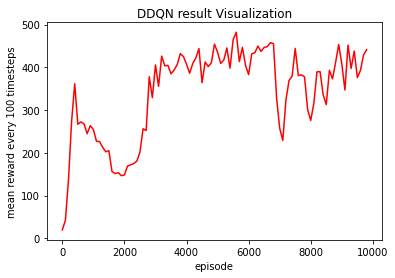

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(0,len(result_DDQN*100),100), result_DDQN, color='red')
plt.xlabel("episode")
plt.ylabel("mean reward every 100 timesteps")
plt.title("DDQN result Visualization")

## DDQN with Dueling network architecture

마찬가지로 DQN의 코드의 큰 틀은 변하지 변하지 않았습니다

Target을 계산할떄 위에서 설명한 DDQN target으로 계산을 했고, 네트워크의 구조만 Dueling network 구조로 변경해 보았습니다.

Forward 부분에서는 위의 그림과 같이 논문에서 제안한, 정확한 Advantage 계산을 강제하기 위해서 위와 같이 Advatnage의 평균을 계산해 제약식을 걸어줍니다. Q =V+Advantage- Advantage mean을 해줍니다(이론적으로 Advatange의 평균은 0이기 때문에 빼도 상관이 없어야 합니다) 
계산한 Q_value를 forward Propagation 합니다.



In [ ]:

class Dueling_Q_network(nn.Module):
    def __init__(self):  # 8 4 2 1
        super(Dueling_Q_network, self).__init__()
        self.fc1 = nn.Linear(4, 128) # fc1 : state를 받아서, 128개 Output
        self.fc_value = nn.Linear(128,1) # fc_value : fc1의 128개 Output을 input으로 받아 Value function 게산 , Output 1 
        self.fc_advantage = nn.Linear(128,2) # fc_advatnage : fc1의 128개 Output을 input으로 받아 Advantage function 게산 , Output 4 


    def forward(self, x):
        x = F.relu(self.fc1(x))
        value = (self.fc_value(x))
        advantage = (self.fc_advantage(x))
        
        Average_advantage = advantage.mean() # Advantage의 평균 계산 
        Q = value + advantage - Average_advantage # 정확한 Advatngae 계산을 강제하기 위한 제약식 
    
        return Q

In [ ]:
import math

class DDQN_Duel_Agent:
    def __init__(self, learning_rate=0.005, gamma=1.0, exploration_rate=1.0, exploration_min=0.1,
                 exploration_decay=200, sample_batch_size=512, max_memory=100000, epochs=10,seed=1):
        
        torch.manual_seed(seed)
        # hyper parameter
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.exploration_rate = exploration_rate
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay
        self.sample_batch_size = sample_batch_size
        self.max_memory = max_memory
        self.epochs = epochs
        
        
        self.replay_buffer = Replay_buffer(size_limit=max_memory, sample_size=sample_batch_size)
        self.brain = Dueling_Q_network() 
        self.target_brain = Dueling_Q_network()
        self.target_brain.load_state_dict(self.brain.state_dict())
        self.optimizer = optim.Adam(self.brain.parameters(), lr=self.learning_rate)
        
        self.steps_done = 0
        self.current_eps = 0 

    def random_act(self): 
        return random.randint(0,1)
        

    def epsilon_greedy_action(self, state):
        u = np.random.rand()
        
        eps_threshold = self.exploration_min+ (self.exploration_rate -self.exploration_min) * \
        math.exp(-1. * self.steps_done / self.exploration_decay)
        self.current_eps = eps_threshold
        
        #greedy action 
        if u > eps_threshold:
            with torch.no_grad():
                out = self.brain(torch.tensor(state, dtype=torch.float)) # 현재 state를 받아 Qvalue output
                return out.argmax().item() # Q-value 중 가장 큰 action을 return

        # random action
        else:
            return self.random_act()

            

    def replay(self):
        self.target_brain.eval()
        self.brain.train()
        for i in range(self.epochs):
            mini_batch = self.replay_buffer.sample() #replay buffer에서 random sampling 
            
            # mini batch 구성
            state_list, action_list, reward_list, next_state_list, done_list = [], [], [], [], []
            
            # tuple로 구성된 trainsition (s, a, r, s`, done)을 분리
            for transition in mini_batch: 
                state, action, reward, next_state, done = transition  # unpack
                state_list.append(state)
                action_list.append([action])
                reward_list.append([reward])
                next_state_list.append(next_state)
                done_list.append([done])

            # 토치 텐서로 변경
            state, action, reward, next_state, done = torch.tensor(state_list, dtype=torch.float), torch.tensor(action_list), \
                               torch.tensor(reward_list, dtype=torch.float), torch.tensor(next_state_list,dtype=torch.float),\
                               torch.tensor(done_list)
            
            q_out = self.brain(state) # state를 forward propagate Q_value 산출
            q_a = q_out.gather(1, action)  # 그중 실제 취한 action의 Q_value, Q(s,a)
            
            # for DDQN
            q_max_out_brain_index = self.brain(next_state).argmax(1)  # leanring agent의 Q값중 큰 action
            DDQN_target_value = self.target_brain(next_state).gather(1, q_max_out_brain_index.unsqueeze(1))


            target = reward + self.gamma * DDQN_target_value *done # target, r+ gamma * max Q(s`,a`)
            
            # loss = r+gamma*max(s`,a`) - Q(s,a)
            loss = F.smooth_l1_loss(target, q_a) 
            
            self.optimizer.zero_grad() 
            loss.backward() # backpropagate 
            self.optimizer.step() # update weight

    def update_target_brain(self):
        # copy weight of learned brain to target brain
        self.target_brain.load_state_dict((self.brain.state_dict()))

In [ ]:
import datetime
import time
import numpy as np

# hyper parameter setting
LR = 0.0001
GAMMA = 0.98
MAX_MEMORY = 50000
SAMPLE_BATCH_SIZE =64
EXPLORATION_RATE = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY= 300
EPISODE = 10000
UPDATE_INTERVAL = 20 # target network update 주기 설정

# for display and result checking 
PRINT_INTERVAL = 100
DISPLAY = True



# build environment
env = gym.make('CartPole-v1')
agent = DDQN_Duel_Agent(learning_rate=LR, gamma=GAMMA, exploration_rate=EXPLORATION_RATE,
              exploration_decay=EXPLORATION_DECAY,
              exploration_min=EXPLORATION_MIN, sample_batch_size=SAMPLE_BATCH_SIZE, max_memory=MAX_MEMORY,
              )


performence = 0
frames = []
result_duel = [] # 결과 저장용 

for epi_i in range(EPISODE):
    state = env.reset() 
    done = False 

    while True : # 한 episode가 끝날때 까지 
        action = agent.epsilon_greedy_action(state) # 현재 e-greedy 정책에 의해 action을 선택
        next_state, reward, done, _ = env.step(action) # action을 한뒤 env부터 transition 결과 받음
        done_mask = 0.0 if done else 1.0 # epside가 끝나면 done , boolean to float 로 변경 
        agent.replay_buffer.put((state, action, reward/100, next_state, done_mask)) # replay buffer 저장
        state = next_state  # state transition
        performence+=reward # 받은 reward를 누적 
        
        # DISPALY = TRUE로 설정시, 평균 reward가 350번을 넘으면 한번만 rendering 합니다(계속하면 너무 오래걸려서..)
        # if DISPLAY and (performence/PRINT_INTERVAL > 400) :
        #     frames.append(env.render(mode = 'rgb_array'))
        #     env.render()
        #     time.sleep(0.01) 
        #     DISPLAY=False  
        
        if done : 
            agent.steps_done+=1 # e-greedy 정책을 위해 한번 episode가 끝나면 steps_done +1 해줌 
            break  # 끝나면 While True문 탈출
    
    # buffer에 충분히 sample이 저장되면, replay 학습 
    if agent.replay_buffer.size() > 2000 :
        agent.replay()
    
    # target network의 weight를 actual network의 weight으로 update_interval 마다 카피해서 update
    if (epi_i % UPDATE_INTERVAL)==0 and epi_i !=0 : 
        agent.update_target_brain()
    
    # PRINT INTERVAL 동안 평균 reward, exploration_rate, buffer size를 checking 
    if (epi_i % PRINT_INTERVAL)==0 and epi_i !=0 :
        print(f'episode {epi_i}, performence : {(performence/PRINT_INTERVAL):.3f}, eps : {agent.current_eps:.3f}, buffer size {agent.replay_buffer.size()}')
        result_duel.append(performence/PRINT_INTERVAL) # PRINT INTERVAL 동안 평균 reward,  결과 시각화를 위한 저장 
        performence = 0.0 
        
env.close()

episode 100, performence : 20.830, eps : 0.719, buffer size 2083
episode 200, performence : 34.160, eps : 0.518, buffer size 5499
episode 300, performence : 89.670, eps : 0.374, buffer size 14466
episode 400, performence : 210.550, eps : 0.271, buffer size 35521
episode 500, performence : 204.710, eps : 0.197, buffer size 50000
episode 600, performence : 211.320, eps : 0.144, buffer size 50000
episode 700, performence : 236.140, eps : 0.106, buffer size 50000
episode 800, performence : 226.740, eps : 0.079, buffer size 50000
episode 900, performence : 267.380, eps : 0.059, buffer size 50000
episode 1000, performence : 289.320, eps : 0.045, buffer size 50000
episode 1100, performence : 324.050, eps : 0.035, buffer size 50000
episode 1200, performence : 290.380, eps : 0.028, buffer size 50000
episode 1300, performence : 282.870, eps : 0.023, buffer size 50000
episode 1400, performence : 309.530, eps : 0.019, buffer size 50000
episode 1500, performence : 288.950, eps : 0.017, buffer size 

Text(0.5, 1.0, 'DDQN with Dueling network result Visualization')

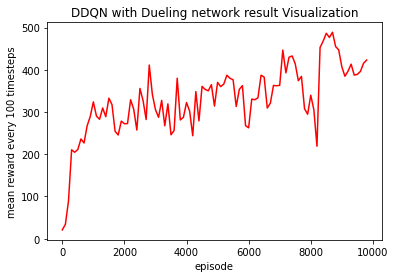

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(0,len(result_duel*100),100), result_duel, color='red')
plt.xlabel("episode")
plt.ylabel("mean reward every 100 timesteps")
plt.title("DDQN with Dueling network result Visualization")

## 알고리즘 별 비교 시각화

일반적인 DQN에 비해서 다른 알고리즘들을 적용했을 때, 드라마틱 하게 달라지는 결과는 관찰되지 못했습니다. 이유는 카트폴 환경이 action이 2가지 밖에 없는 비교적 단순한 환경이기 때문일 것이라 생각됩니다.


**모델의 실질적인 성능의 비교는 무의미 할 정도로 비슷합니다.\
세가지 알고리즘 모두 성능이 우수한 것을 확인할 수 있고 
 다만 관찰되는 알고리즘 별 특징은 다음과 같습니다.**

+ DQN은 우선 편차가 매우 심합니다. 주황색 선을 보면 급격하게 낮아졌다가 높아지는 구간을 많이 관찰할 수 있습니다. 
+ 이에 비해 DDQN은 편차의 폭이 조금 줄은 것을 확인 할 수 있습니다. 
+  DDQN-Dueling network은 대체로 큰 편차 없이 서서히 우 상향하는 그림을 보여줍니다. 



Cartpole v0 환경기준 195점을 세 알고리즘 모두 다 episode 초반부에서 모두 넘어 버렸습니다(max 200) 그렇기 때문에 Cartpole v1 환경을 다시 돌렸습니다(동일한 환경이지만 max 500까지 갈수 있습니다). Cartpole v1 기준의 max값인 500을 DDQN-Dueling network, DQN는 도달한 결과를 관찰 할 수 있습니다. 




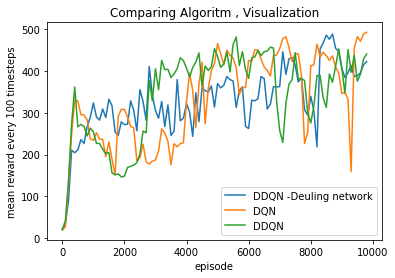

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(0,len(result_duel*100),100), result_duel, label='DDQN -Deuling network')
plt.plot(range(0,len(result_DQN*100),100), result_DQN, label='DQN')
plt.plot(range(0,len(result_DDQN*100),100), result_DDQN, label='DDQN')
plt.xlabel("episode")
plt.ylabel("mean reward every 100 timesteps")
plt.title("Comparing Algoritm , Visualization")
plt.legend()